In [1]:
from matplotlib import pyplot as plt 

In [2]:
import json

In [3]:
import re

In [4]:
import numpy as np

In [5]:
def bucket(x, size):
    l = len(x)
    buckets = []
    i = 0
    while i < l:
        buckets.append(sum(x[i:i+size])/len(x[i:i+size]))
        i+=size
    return buckets

In [6]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [7]:
class LogReader():
    def __init__(self, filename, keys):
        self.file = open(f'{filename}')
        self.keys = set(keys)
        self.matches = {}
        for key in keys:
            self.matches[key]=[]
    
    def grab(self):
        line = next(self.file, None)
        while line:
            split = line.strip().split('=')
            if len(split)==2:
                query = split[0]
                value = float(split[1])
                if query in self.keys:
                    self.matches[query].append(value)
            line = next(self.file, None)
        return self.matches

In [8]:
tasks = [
    ('atac_region', 'gene'),
    ('gene', 'atac_region'),
    ('gene', 'protein_name'),
    ('protein_name', 'gene'),
]

In [9]:
base_keys = [
    'train zero one loss',
    'train value loss',
    'train prediction loss',
    'validation zero one loss',
    'validation value loss',
    'validation prediction loss',
]

keys = []
for key in base_keys:
    for task in tasks:
        keys.append(f'{key} {task}')

In [10]:
keys += [
    'Batch',
    'Epoch',
]

#### Bucket Size

In [11]:
bucket_size = 10

In [12]:
readers = {}
matches = {}

#### Timestamp of run

In [13]:
timestamps = [
    '20211115-1420',
    '20211116-0941',
]
files = [f'logs/train_earl_{tmstp}.log' for tmstp in timestamps]

In [14]:
for file in files:
    if file not in readers:
        readers[file] = LogReader(file, keys)


[0.4175683921575547,
 0.5300500619411469,
 0.4139716890454293,
 0.336895152926445,
 0.3415050929784774]

In [68]:
for task in tasks:
    print(f'{task[0]} -> {task[1]}')
    for tmstp in timestamps:
        print(tmstp, end=': ')
        matches = readers[f'logs/train_earl_{tmstp}.log'].grab()
        for i in range(5,0,-1):
            print('{:.3f}'.format(matches[f'validation prediction loss {task}'][-i]), end=' ')
        print()
    print('-------')

atac_region -> gene
20211115-1420: 0.295 0.278 0.309 0.340 0.329 
20211116-0941: 0.390 0.466 0.385 0.335 0.330 
-------
gene -> atac_region
20211115-1420: 0.171 0.187 0.190 0.188 0.191 
20211116-0941: 0.185 0.187 0.190 0.207 0.190 
-------
gene -> protein_name
20211115-1420: 0.262 0.231 0.253 0.257 0.232 
20211116-0941: 0.362 0.306 0.316 0.262 0.296 
-------
protein_name -> gene
20211115-1420: 0.277 0.253 0.280 0.324 0.275 
20211116-0941: 0.418 0.530 0.414 0.337 0.342 
-------


## Select File

In [31]:
idx = 0

## Get matching log lines

In [32]:
file = files[idx]
matches = readers[file].grab()

## Parameters of this run

In [33]:
import json
from pprint import pprint

In [34]:
pprint(json.load(open(f'logs/earl_params_{timestamps[idx]}.json')))

{'atac_ones_weight': 1,
 'checkpoint': 25,
 'device': 'cuda:3',
 'gene_ones_weight': 1,
 'layers': [['SAGEConv', {'out_channels': 128}],
            ['SAGEConv', {'out_channels': 128}],
            ['SAGEConv', {'out_channels': 128}],
            ['SAGEConv', {'out_channels': 128}],
            ['SAGEConv', {'out_channels': 128}],
            ['SAGEConv', {'out_channels': 128}],
            ['SAGEConv', {'out_channels': 128}],
            ['SAGEConv', {'out_channels': 128}]],
 'lr': 0.001,
 'n_steps': 15000,
 'out_mlp': {'bias': True,
             'dim_in': 128,
             'dim_inner': 512,
             'dim_out': 1,
             'num_layers': 4},
 'train_batch_size': 5,
 'validation_batch_size': 100}


## Current Batch

In [35]:
batch = matches['Batch'][-1]
batch

3277.0

## Training loss

('atac_region', 'gene') 0.3209
('gene', 'atac_region') 0.2101
('gene', 'protein_name') 0.3377
('protein_name', 'gene') 0.2316


<Figure size 1080x720 with 0 Axes>

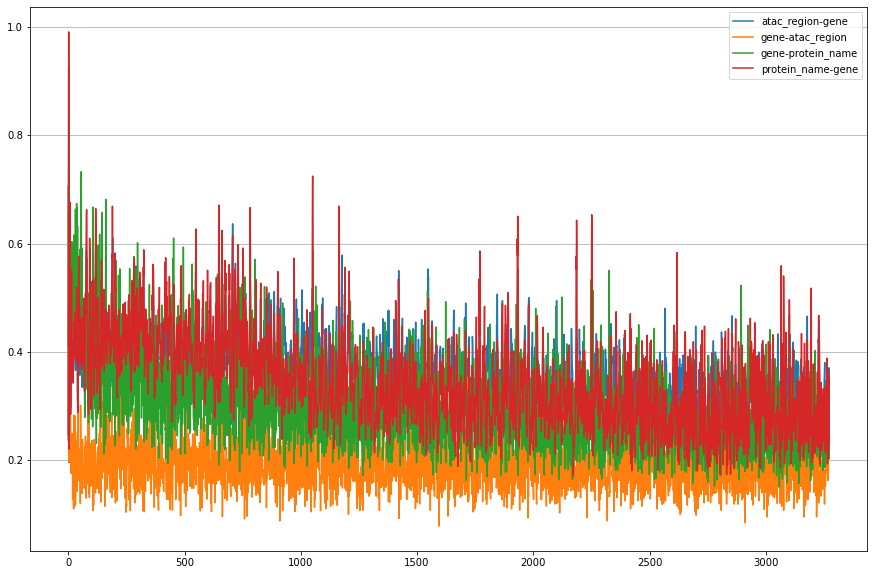

In [36]:
plt.figure(figsize=(15,10))
fig,ax = plt.subplots(figsize=(15,10))
plt.grid(axis='y')

for task in tasks:
    training_loss = matches[f'train prediction loss {task}']
    ax.plot(training_loss[5:], label=f'{task[0]}-{task[1]}')
    print(task, f'{training_loss[-1]:.4f}')
_=ax.legend()


('atac_region', 'gene') 0.32093870639801025
('gene', 'atac_region') 0.21010282933712005
('gene', 'protein_name') 0.33765127658843996
('protein_name', 'gene') 0.23163790106773374


<Figure size 1080x720 with 0 Axes>

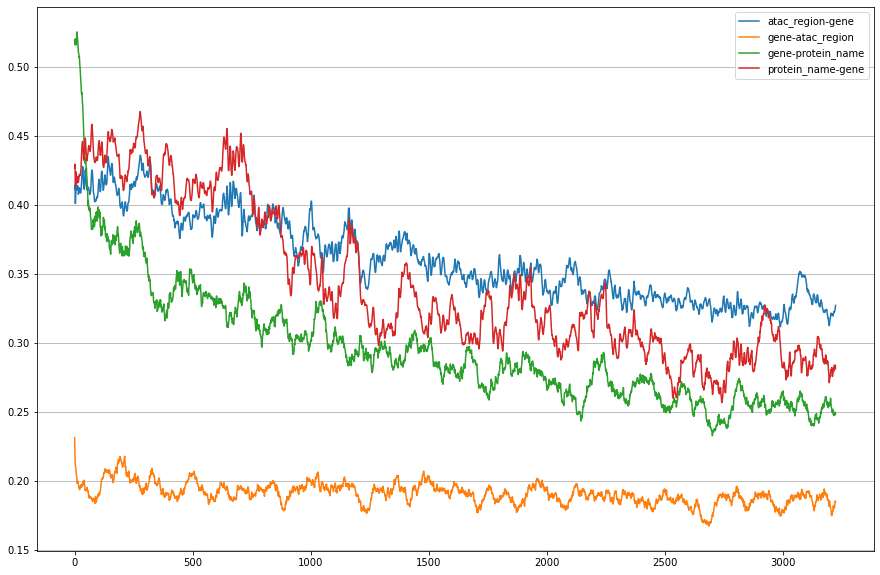

In [37]:
plt.figure(figsize=(15,10))
fig,ax = plt.subplots(figsize=(15,10))
plt.grid(axis='y')

for task in tasks:
    training_loss = matches[f'train prediction loss {task}']
    ax.plot(moving_average(training_loss[5:],50), label=f'{task[0]}-{task[1]}')
    print(task, training_loss[-1])
_=ax.legend()


## Validation Loss

('atac_region', 'gene') 0.3400850436091424
('gene', 'atac_region') 0.18775564432144165
('gene', 'protein_name') 0.25725789830088625
('protein_name', 'gene') 0.3236777006089687


<Figure size 1080x720 with 0 Axes>

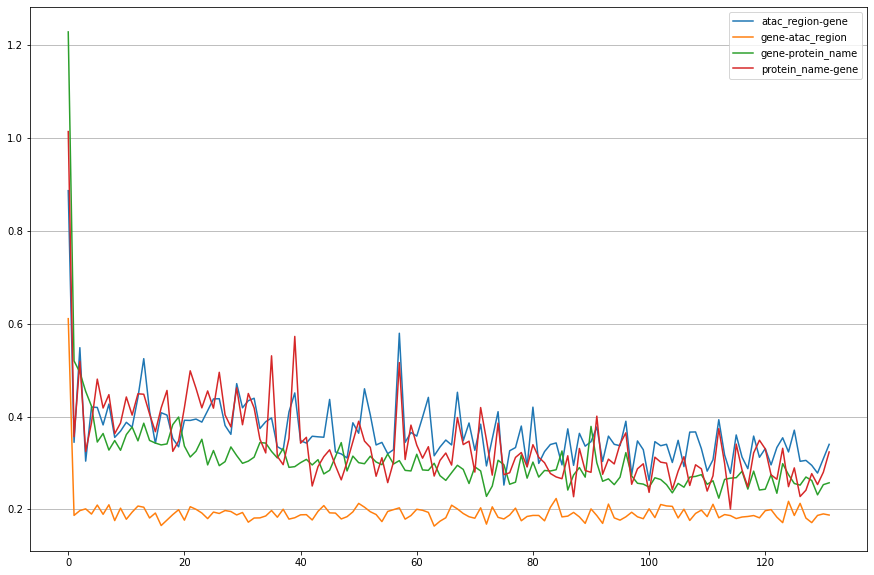

In [38]:
plt.figure(figsize=(15,10))
fig,ax = plt.subplots(figsize=(15,10))
plt.grid(axis='y')

for task in tasks:
    validation_loss = matches[f'validation prediction loss {task}']
    _=ax.plot(validation_loss, label=f'{task[0]}-{task[1]}')
    print(task, validation_loss[-1])
_=ax.legend()

## Sample predictions

In [39]:
prediction_file = open(f'logs/train_earl_prediction_sample_{timestamps[idx]}.log')

In [40]:
import time

In [41]:
for line in prediction_file:
    print(line.strip())
    time.sleep(.01)    

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



batch 3275 4      pred,y:   0.000 0.000
batch 3275 5      pred,y:   0.000 0.000
batch 3275 6      pred,y:   0.000 0.000
batch 3275 7      pred,y:   0.000 0.000
batch 3275 8      pred,y:   0.000 0.000
batch 3275 9      pred,y:   0.000 0.000
batch 3275 10     pred,y:   1.358 0.000
batch 3275 11     pred,y:   1.234 0.000
batch 3275 12     pred,y:   0.000 0.000
batch 3275 13     pred,y:   0.000 0.000
batch 3275 14     pred,y:   0.000 0.000
batch 3275 15     pred,y:   0.000 1.435
batch 3275 16     pred,y:   0.000 1.435
batch 3275 17     pred,y:   0.000 0.000
batch 3275 18     pred,y:   0.000 0.000
batch 3275 19     pred,y:   0.000 0.000
batch 3275 20     pred,y:   0.000 0.000
batch 3275 21     pred,y:   1.258 1.435
batch 3275 22     pred,y:   0.000 0.000
batch 3275 23     pred,y:   0.000 0.000
batch 3275 24     pred,y:   0.000 0.000
batch 3275 25     pred,y:   0.000 1.435
batch 3275 26     pred,y:   0.000 0.000
batch 3275 27     pred,y:   0.000 0.000
batch 3275 28     pred,y:   0.000 0.000


batch 3275 213    pred,y:   0.000 0.000
batch 3275 214    pred,y:   0.000 0.000
batch 3275 215    pred,y:   0.000 0.000
batch 3275 216    pred,y:   0.000 0.000
batch 3275 217    pred,y:   0.000 0.000
batch 3275 218    pred,y:   0.000 0.000
batch 3275 219    pred,y:   0.000 0.000
batch 3275 220    pred,y:   0.000 0.000
batch 3275 221    pred,y:   0.000 0.000
batch 3275 222    pred,y:   0.000 0.000
batch 3275 223    pred,y:   0.000 0.000
batch 3275 224    pred,y:   0.909 0.000
batch 3275 225    pred,y:   0.000 0.000
batch 3275 226    pred,y:   0.000 0.000
batch 3275 227    pred,y:   0.000 0.000
batch 3275 228    pred,y:   0.000 1.435
batch 3275 229    pred,y:   0.000 0.000
batch 3275 230    pred,y:   0.000 0.000
batch 3275 231    pred,y:   0.000 0.000
batch 3275 232    pred,y:   0.000 0.000
batch 3275 233    pred,y:   0.000 0.000
batch 3275 234    pred,y:   0.000 0.000
batch 3275 235    pred,y:   0.000 0.000
batch 3275 236    pred,y:   0.000 0.000
batch 3275 237    pred,y:   0.000 0.000


batch 3275 113    pred,y:   0.000 0.402
batch 3275 114    pred,y:   0.000 0.555
batch 3275 115    pred,y:   0.707 0.805
batch 3275 116    pred,y:   0.000 0.402
batch 3275 117    pred,y:   0.310 0.221
batch 3275 118    pred,y:   0.475 0.000
batch 3275 119    pred,y:   1.027 1.004
batch 3275 120    pred,y:   0.000 0.000
batch 3275 121    pred,y:   0.458 0.402
batch 3275 122    pred,y:   0.000 0.555
batch 3275 123    pred,y:   0.302 0.221
batch 3275 124    pred,y:   0.486 0.221
batch 3275 125    pred,y:   0.420 0.000
batch 3275 126    pred,y:   0.000 0.000
batch 3275 127    pred,y:   0.455 0.687
batch 3275 128    pred,y:   1.239 1.171
batch 3275 129    pred,y:   0.000 0.000
batch 3275 130    pred,y:   0.712 1.004
batch 3275 131    pred,y:   1.379 0.687
batch 3275 132    pred,y:   0.623 0.909
batch 3275 133    pred,y:   1.347 1.004
--------------------------------------------------------------------------------
Task: ('atac_region', 'gene')
-------------------------------------------------

batch 3275 198    pred,y:   0.000 0.000
batch 3275 199    pred,y:   0.000 0.000
batch 3275 200    pred,y:   0.000 0.000
batch 3275 201    pred,y:   0.000 0.000
batch 3275 202    pred,y:   0.000 0.000
batch 3275 203    pred,y:   0.000 0.000
batch 3275 204    pred,y:   0.000 0.000
batch 3275 205    pred,y:   0.000 0.000
batch 3275 206    pred,y:   0.000 1.958
batch 3275 207    pred,y:   0.000 0.000
batch 3275 208    pred,y:   0.000 0.000
batch 3275 209    pred,y:   0.000 0.000
batch 3275 210    pred,y:   0.000 0.000
batch 3275 211    pred,y:   0.000 0.000
batch 3275 212    pred,y:   0.000 0.000
batch 3275 213    pred,y:   0.000 0.000
batch 3275 214    pred,y:   1.348 0.000
batch 3275 215    pred,y:   0.000 0.000
batch 3275 216    pred,y:   0.000 0.000
batch 3275 217    pred,y:   0.000 0.000
batch 3275 218    pred,y:   0.000 1.958
batch 3275 219    pred,y:   0.000 0.000
batch 3275 220    pred,y:   0.000 0.000
batch 3275 221    pred,y:   0.000 0.000
batch 3275 222    pred,y:   1.702 1.958


batch 3275 118    pred,y:   0.040 0.000
batch 3275 119    pred,y:   0.052 0.000
batch 3275 120    pred,y:   0.023 0.000
batch 3275 121    pred,y:   0.062 0.000
batch 3275 122    pred,y:   0.021 0.000
batch 3275 123    pred,y:   0.024 0.000
batch 3275 124    pred,y:   0.041 0.000
batch 3275 125    pred,y:   0.016 0.000
batch 3275 126    pred,y:   0.036 0.000
batch 3275 127    pred,y:   0.029 0.000
batch 3275 128    pred,y:   0.020 0.000
batch 3275 129    pred,y:   0.045 0.000
batch 3275 130    pred,y:   0.060 0.000
batch 3275 131    pred,y:   0.121 0.000
batch 3275 132    pred,y:   0.020 0.000
batch 3275 133    pred,y:   0.041 0.000
batch 3275 134    pred,y:   0.049 0.000
batch 3275 135    pred,y:   0.051 0.000
batch 3275 136    pred,y:   0.030 0.000
batch 3275 137    pred,y:   0.053 0.000
batch 3275 138    pred,y:   0.019 0.000
batch 3275 139    pred,y:   0.044 0.000
batch 3275 140    pred,y:   0.048 0.000
batch 3275 141    pred,y:   0.019 0.000
batch 3275 142    pred,y:   0.032 0.000
